In [1]:
import torch
import torch.nn as nn
import torchsde
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [3]:
# Generate the training set

# Define the velocity field 
uvec = np.array([4.0, 0.0, 0.0])

# Define the gravitational settling velocity 
ugvec = np.array([0.0, 0.0, -0.1])

# Initialize parameters
n_particles = 1  # Single initial condition
dt = 0.01  # Time step
tfinal = 60  # Total simulation time
t = np.arange(0, tfinal + dt, dt)  # Time vector

# Define ONE fixed initial position
fixed_x0 = np.array([0.0, 0.0, 25.0])  # (x=0, y=0, z=10)

# Number of simulations from this same initial position
n_simulations = 250  

# Initialize dataset lists
batch_inputs = []
batch_outputs = []

# Function defining the particle dynamics
def dispersion_deriv(pos, t0, u, u_g, rx, ry, reta):
    a = 0.5
    b = 0.875
    leta = 0.08
    wind_speed = np.sqrt(u[0]**2 + u[1]**2)
    
    # Pick random fluctuation at current time step
    t_idx = min(int(t0 / dt), len(rx) - 1)  # Ensure valid index
    fluct_x = rx[t_idx] * a * (wind_speed * dt) ** b
    fluct_y = ry[t_idx] * a * (wind_speed * dt) ** b
    fluct_z = reta[t_idx] * leta

    return [u[0] + u_g[0] + fluct_x, 
            u[1] + u_g[1] + fluct_y, 
            u[2] + u_g[2] + fluct_z]

# Generate 100 different stochastic simulations from the same initial condition
for i in range(n_simulations):
    np.random.seed(i)  # Different seed for different stochastic runs
    rx = np.random.uniform(-0.5, 0.5, size=len(t))
    ry = np.random.uniform(-0.5, 0.5, size=len(t))
    reta = np.random.uniform(-0.5, 0.5, size=len(t))

    # Solve ODE for this particular random realization
    x_t = odeint(dispersion_deriv, fixed_x0, t, args=(uvec, ugvec, rx, ry, reta))

    # Prepare inputs and outputs for training
    single_nninput = x_t[:-1, :]  # All time steps except the last one
    single_nnoutput = x_t[1:, :]  # From the second time step to the last

    # Add to dataset
    batch_inputs.append(single_nninput)
    batch_outputs.append(single_nnoutput)


In [ ]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

cuda:0


In [72]:
# Define the NSDE
class ParticleNSDE(torchsde.SDEIto):  
    def __init__(self):
        super().__init__(noise_type="diagonal")  # Diagonal noise (independent per dimension)
        
        # Learnable parameters for the deterministic and stochastic terms
        self.f_net = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3)
        )
        
        self.g_net = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3),
        )

        # Fixed velocity components
        self.uvec = torch.tensor([4.0, 0.0, 0.0], dtype=torch.float32)
        self.ugvec = torch.tensor([0.0, 0.0, -0.1], dtype=torch.float32)
    
    def to(self, device):
        # Move the model and its tensor attributes to the specified device
        super(ParticleNSDE, self).to(device)
        self.uvec = self.uvec.to(device)
        self.ugvec = self.ugvec.to(device)
        return self

    def f(self, t, y):
        """Deterministic drift term: advection + gravitational settling"""
        return self.f_net(y) + self.uvec + self.ugvec

    def g(self, t, y):
        """Stochastic diffusion term: turbulent fluctuations"""
        return self.g_net(y)  # Learned noise function

In [73]:
# Convert to tensors
X_data = torch.tensor(np.concatenate(batch_inputs, axis=0), dtype=torch.float32).to(device)  # (n_samples, 3)
Y_data = torch.tensor(np.concatenate(batch_outputs, axis=0), dtype=torch.float32).to(device)  # (n_samples, 3)

print("Dataset shape:", X_data.shape, Y_data.shape)

# Use mini-batches
batch_size = 64
dataset = torch.utils.data.TensorDataset(X_data, Y_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Dataset shape: torch.Size([1500000, 3]) torch.Size([1500000, 3])


In [74]:
# Initialize the NSDE model
model = ParticleNSDE()
model.to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Move dt to gpu

# Training loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    
    for X_batch, Y_batch in dataloader:
        optimizer.zero_grad()
        
        # Simulate NSDE forward in time
        t_span = torch.linspace(0, dt, 2).to(device)  # Single time step per batch
        y0 = X_batch
        
        y_pred = torchsde.sdeint(model, y0, t_span, dt=dt)[-1]
        
        # Compute loss
        loss = criterion(y_pred, Y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")

# Batch size 8196: GPU 2m 22.1s, weird results on GPU
# Batch size 4096: GPU 2m 19.3s, 
# Batch size 2048: GPU 2m 25.9s, CPU 3m 17.9s, again ran into problem of mostly smooth descent and then noise at end with CPU. This time GPU worked more or less fine
# Batch size 1024: CPU 3m 47.5s,GPU 2m 58.6s, but get initial smooth path, then super noisy towards the end. For CPU it works fine??
# Batch Size 512: GPU 5m 24s, CPU 4m 26s, but get really weird results
# Batch Size 64: CPU 13m 33.1s seems to work

Epoch 1, Loss: 0.0002427415666322396
Epoch 2, Loss: 5.049797529701962e-05
Epoch 3, Loss: 3.518269798528793e-05


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "trained_models/particle_nsde_singleIC.pth")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# Initial condition
y0 = torch.tensor([[0.0, 0.0, 25.0]], dtype=torch.float32).to(device)  # Example initial position

# Time span
t_eval = torch.linspace(0, 60, 6000).to(device)  # Full simulation

# Solve the NSDE
with torch.no_grad():
    y_sim = torchsde.sdeint(model, y0, t_eval, dt=dt)

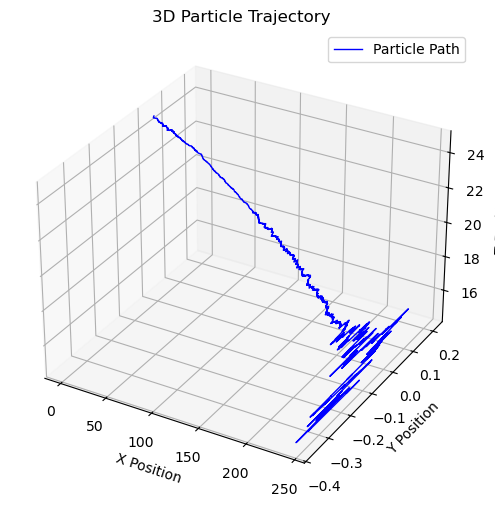

In [ ]:
# Convert to NumPy and plot
y_sim = y_sim.cpu().numpy()

# Remove the extra batch dimension
y_sim = y_sim.squeeze(1)  # Shape: (6000, 3)

# Extract x, y, and z coordinates
x, y, z = y_sim[:, 0], y_sim[:, 1], y_sim[:, 2]

# Create a 3D figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
ax.plot(x, y, z, label="Particle Path", color='b', linewidth=1)

# Labels and title
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_zlabel("Z Position")
ax.set_title("3D Particle Trajectory")

# Show the legend
ax.legend()

# Display the plot
plt.show()